# Realized Volatility Prediction
## 1 Data Wrangling and Exploratory Data Analysis

### Table of Contents
#### Data Wrangling
1. Introduction and Data Organization
2. Library and File Imports
#### Exploratory Data Analysis
3. Time Series

## 1 Introduction and Data Organization

The project is taken from the Optiver Realized Volatility Prediction competition on Kaggle. The dataset is available for download here (https://www.kaggle.com/competitions/optiver-realized-volatility-prediction/data).

The primary unit in this dataset is a "bucket." Each bucket is uniquely identified by a 'stock_id' and a 'time_id,' giving a picture of a particular stock over a specific 10-minute window. Each bucket contains time-serialized snapshots of the order book as well as records of executed trades. These features form the basis for making predictions.

The target value associated with each bucket is also provided in the training data; this value is the realized volatility of the same stock over the subsequent 10 minutes. Below is a more detailed description of the three files used for training.

### book_train.parquet

This is a parquet file partitioned by 'stock_id'; each partition contains multiple buckets (same stock, different 10-minute windows). The rows in the partitions are order book snapshots, serialized according to 'seconds_in_bucket'. 

An example of an order book snapshot:

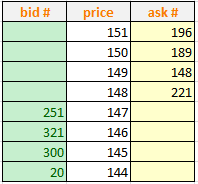

### trade_train.parquet

Similar to book_train.parquet, this is also partitioned by 'stock_id'. However, instead of order book snapshots, the rows are records of trades executed on the stock. Therefore the records are more sparse.

### train.csv

This contains the ground truth values for each bucket.

## 2 Library and File Imports

In [1]:
# Standard imports and libraries
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Target (train.csv)
train = pd.read_csv('../data/raw/train.csv')
train.head()

,stock_id,time_id,target
0,0,5,0.004136
1,0,11,0.001445
2,0,16,0.002168
3,0,31,0.002195
4,0,62,0.001747


Here we could see each row represents a bucket. Let us select row 3 for example; this bucket has stock_id = 0, so we will look at the book and trade files with this stock_id.

In [4]:
# Feature (book_train.parquet and trade_train.parquet, stock_id=0)
book_path = '../data/raw/book_train.parquet/stock_id='
trade_path = '../data/raw/trade_train.parquet/stock_id='
stock_id = 0

In [6]:
book_example = pd.read_parquet(book_path + str(stock_id))
book_example.head()

,time_id,seconds_in_bucket,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2
0,5,0,1.001422,1.002301,1.00137,1.002353,3,226,2,100
1,5,1,1.001422,1.002301,1.00137,1.002353,3,100,2,100
2,5,5,1.001422,1.002301,1.00137,1.002405,3,100,2,100
3,5,6,1.001422,1.002301,1.00137,1.002405,3,126,2,100
4,5,7,1.001422,1.002301,1.00137,1.002405,3,126,2,100


In [9]:
trade_example = pd.read_parquet(trade_path + str(stock_id))
trade_example.head()

,time_id,seconds_in_bucket,price,size,order_count
0,5,21,1.002301,326,12
1,5,46,1.002778,128,4
2,5,50,1.002818,55,1
3,5,57,1.003155,121,5
4,5,68,1.003646,4,1


Each dataframe should contain information on multiple buckets of the same stock_id but different time_id; let us verify by counting the unique values of time_id in each.

In [11]:
print(book_example.time_id.nunique())

3830


In [12]:
print(trade_example.time_id.nunique())

3830


Now that we have established the relationships between these tables, let us focus on our single bucket on row 3 of train.csv; it has time_id = 31.

In [14]:
time_id = 31
book_bucket = book_example[book_example['time_id'] == time_id]
trade_bucket = trade_example[trade_example['time_id'] == time_id]

In [15]:
book_bucket.head()

,time_id,seconds_in_bucket,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2
690,31,0,0.999815,1.000463,0.999722,1.000509,343,100,5,242
691,31,3,0.999815,1.000463,0.999769,1.000509,343,100,5,142
692,31,11,0.999815,1.000509,0.999769,1.000601,343,142,5,100
693,31,27,0.999815,1.000509,0.999769,1.000601,243,142,5,100
694,31,31,0.999815,1.000509,0.999769,1.000601,243,142,5,125


In [17]:
book_bucket.shape

(120, 10)

A description of the columns for reference:

Order book data on the most competitive buy and sell orders entered into the market. The top two levels of the book are shared. The first level of the book will be more competitive in price terms, it will then receive execution priority over the second level.

- stock_id - ID code for the stock. Not all stock IDs exist in every time bucket. Parquet coerces this column to the categorical data type when loaded; you may wish to convert it to int8.
- time_id - ID code for the time bucket. Time IDs are not necessarily sequential but are consistent across all stocks.
- seconds_in_bucket - Number of seconds from the start of the bucket, always starting from 0.
- bid_price[1/2] - Normalized prices of the most/second most competitive buy level.
- ask_price[1/2] - Normalized prices of the most/second most competitive sell level.
- bid_size[1/2] - The number of shares on the most/second most competitive buy level.
- ask_size[1/2] - The number of shares on the most/second most competitive sell level.

In [18]:
trade_bucket.head()

,time_id,seconds_in_bucket,price,size,order_count
95,31,3,1.000231,13,1
96,31,53,1.000231,16,1
97,31,101,0.999745,202,6
98,31,117,0.999260,100,1
99,31,161,0.998381,70,3


In [19]:
trade_bucket.shape

(15, 5)

A description of the columns for reference:

Data on trades that actually executed. Usually, in the market, there are more passive buy/sell intention updates (book updates) than actual trades, therefore one may expect this file to be more sparse than the order book.

- stock_id - Same as above.
- time_id - Same as above.
- seconds_in_bucket - Same as above. Note that since trade and book data are taken from the same time window and trade data is more sparse in general, this field is not necessarily starting from 0.
- price - The average price of executed transactions happening in one second. Prices have been normalized and the average has been weighted by the number of shares traded in each transaction.
- size - The sum number of shares traded.
- order_count - The number of unique trade orders taking place.

So far, the dataframes have the expected format; we will carry on with further investigation in the exploratory data analysis section. For now, let us loop through every file and here are the most important things to make sure of:

1. No null value in any of the fields
2. Every bucket has a target value in train.csv
3. Every bucket has book data for time running from 0 to 600 (10-min)

We will do a single loop through the parquet files, keeping track of the various values for each bucket and output for buckets failing any of the conditions. This checks for (a) if the data is clean, and (b) if we understand the data correctly at this point.

In [ ]:
def check_bucket(time_id):
    